# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 0**

<img src="var_00.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import trange, tqdm
from time import perf_counter
from contextlib import contextmanager
from scipy import signal
import numba as nb

In [ ]:
n = int(input())

960


In [ ]:
po = 1
cp =1

In [ ]:
Lx = 60
Ly = 60
Nx = n
Ny = n
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
dt = 0.3*(dx**2)
Nt = 600

In [ ]:
t_n = np.zeros((Nx, Ny), dtype=np.float64)
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Lx, Nx)
X, Y = np.meshgrid(x, y)

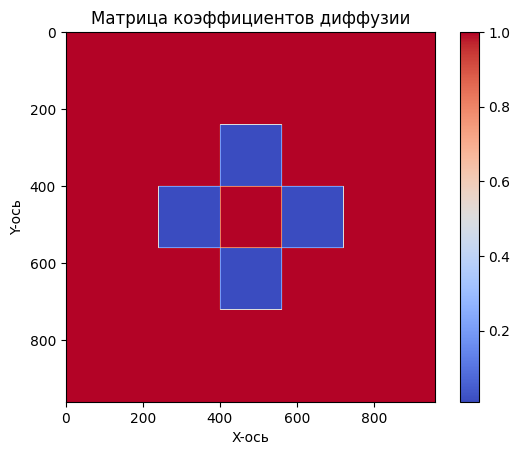

In [ ]:
C = np.ones((Nx, Ny))
shag = Nx // 60
C[shag*15:shag*25, shag*25:shag*35] = 0.01
C[shag*25:shag*35, shag*15:shag*25] = 0.01
C[shag*35:shag*45, shag*25:shag*35] = 0.01
C[shag*25:shag*35, shag*35:shag*45] = 0.01
plt.imshow(C, cmap='coolwarm')

# Добавление цветовой шкалы
plt.colorbar()

# Настройка осей (дополнительно)
plt.xlabel('X-ось')
plt.ylabel('Y-ось')

# Добавление заголовка (дополнительно)
plt.title('Матрица коэффициентов диффузии')

# Отображение графика
plt.show()

In [ ]:
@contextmanager
def catchtime() -> float:
    """
    Измеряет прошедшее время выполнения кода внутри контекстного менеджера.
    """
    start = perf_counter()
    yield lambda: perf_counter() - start

In [ ]:
m_t = 600
prob1 = np.zeros(int(m_t/dt))
prob2 = np.zeros(int(m_t/dt))
prob3 = np.zeros(int(m_t/dt))
prob4 = np.zeros(int(m_t/dt))
x_t = np.array([shag*20, shag*20, shag*40, shag*40], dtype=np.int64)
y_t = np.array([shag*20, shag*40, shag*20, shag*40], dtype=np.int64)

In [ ]:
@nb.njit(parallel=True)
def calculate_t(t_n, Nx, Ny, dt, dx, C, shag, prob1, prob2, prob3, prob4, t,  iter):
    """
    один шаг алгоритма(меняем за один шаг поле температур,
    устанавливаем значению на границах на двух фиксированная и ненулевая температура на двух других
    нулевая, запускаем источник теплоты в определенных местах на карте, записываем замеры проб в соответсвущие массивы)
    """
    for i in nb.prange(1, Nx - 1):
        for j in range(1, Ny - 1):
            g = dt * C[i, j] / dx**2
            t_n[i, j] = t_n[i, j] + \
                        g * (t_n[i+1, j] +
                             t_n[i-1, j] +
                             t_n[i, j+1] +
                             t_n[i, j-1] -
                             4 * t_n[i, j])
    t_n[shag*5:shag*10, shag*20:shag*40] = t_n[shag*5:shag*10, shag*20:shag*40] + dt*(100*(np.sin(2*np.pi*t/43)+1))/(cp*po)
    t_n[shag*20:shag*40, shag*5:shag*10] = t_n[shag*20:shag*40, shag*5:shag*10] + dt*(100*(np.sin(2*np.pi*t/77)+1))/(cp*po)
    t_n[0, :] = 0
    t_n[-1, :] = 50
    t_n[:, 0] = 0
    t_n[:, -1] = 50
      # Пример координат точек

    prob1[iter] = t_n[x_t[0], y_t[0]]
    prob2[iter] = t_n[x_t[1], y_t[1]]
    prob3[iter] = t_n[x_t[2], y_t[2]]
    prob4[iter] = t_n[x_t[3], y_t[3]]


In [ ]:
t = 0
iteraions = int(m_t/dt)
with catchtime() as vremya:
  for v in trange(iteraions):
    t += dt
    calculate_t(t_n, Nx, Ny, dt, dx, C, shag, prob1, prob2, prob3, prob4, t,  v)


np.save('t1.npy', t_n)
np.save('prob1.npy', prob1)
np.save('prob2.npy', prob2)
np.save('prob3.npy', prob3)
np.save('prob4.npy', prob4)


print(f"Execution time on {(n, dt)}: {vremya():.4f} secs")

100%|██████████| 510933/510933 [34:31<00:00, 246.63it/s]

Execution time on (960, 0.0011743202262523638): 2071.6932 secs


In [ ]:
def approx_per(arr, dt):
    """Approximate period for an array of data using Fast Fourier Transforms and peak search"""
    N = arr.size
    r = np.fft.rfft(arr - arr.mean())
    amp = (np.abs(r) / (N / 2))
    freq = np.fft.rfftfreq(N, dt)
    idx, h = signal.find_peaks(amp)
    return 1 / freq[idx]

[array([0.00000000e+00, 2.12048670e-04, 2.15570406e-03, ...,
       1.60142902e+02, 1.59077026e+02, 1.58027890e+02]), array([0.00000000e+00, 1.40158778e-03, 7.24503296e-03, ...,
       7.59321744e+01, 7.55293730e+01, 7.51395499e+01]), array([0.00000000e+00, 1.37476446e-03, 7.08081925e-03, ...,
       7.79694817e+01, 7.74836809e+01, 7.70010621e+01]), array([0.00000000e+00, 3.52464569e-18, 4.01913682e-17, ...,
       1.85023381e+01, 1.85061790e+01, 1.85100018e+01])]
период пробы1 [299.86210859  74.96552715  42.83744408]
период пробы2 [299.86210859  42.83744408]
период пробы3 [299.86210859  74.96552715]
период пробы4 [299.86210859]


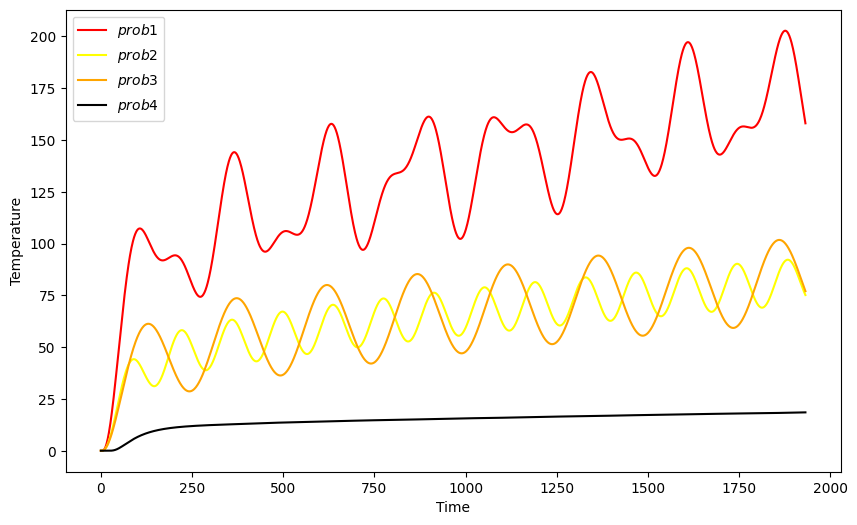

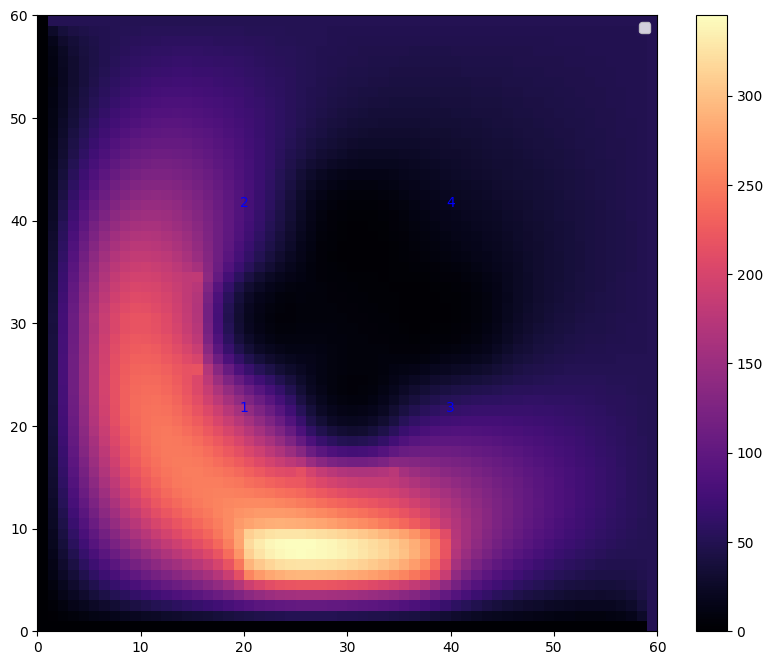

In [ ]:
prob1_r = np.load('prob1.npy')
prob2_r = np.load('prob2.npy')
prob3_r = np.load('prob3.npy')
prob4_r = np.load('prob4.npy')
probs = [prob1_r, prob2_r, prob3_r, prob4_r]
print(probs)
j = 1
for i in probs:
  i_aproximate = np.poly1d(np.polyfit(np.arange(len(i)), i, deg=3))(np.arange(len(i)))
  smeshenie = i - i_aproximate
  periods = approx_per(smeshenie, dt)
  print("период пробы"+str(j), periods)
  j += 1
plt.figure(figsize=(10, 6))
plt.plot(prob1_r, label='$'+"prob1"+'$', color='red')
plt.plot(prob2_r, label='$'+"prob2"+'$', color='yellow')
plt.plot(prob3_r, label='$'+"prob3"+'$', color='orange')
plt.plot(prob4_r, label='$'+"prob4"+'$', color='black')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


Temp = np.load('t1.npy')
plt.figure(figsize=(10, 8))
plt.scatter(x_t, y_t, c='red')
for i, (x_val, y_val) in enumerate(zip(x_t, y_t)):
    plt.annotate(i+1, (x_val, y_val), textcoords="offset points", xytext=(0,10), ha='center', color='blue')  # подпись номеров точек
plt.colorbar(plt.pcolormesh(Temp, cmap='magma'))
plt.legend()
plt.show()

[array([  0.        ,   0.        ,   0.        , ..., 178.48792803,
       178.05270705, 177.61810351]), array([  0.        ,   1.35028592,   2.94062973, ..., 285.17403293,
       285.39282188, 285.63011544]), array([  0.        ,   1.34371501,   2.91982274, ..., 244.93017275,
       244.16136064, 243.39946365]), array([0.00000000e+00, 5.07774510e-10, 1.37450876e-08, ...,
       1.72801900e+02, 1.72538092e+02, 1.72275376e+02])]
период пробы1 [299.99152602  74.99788151  42.85593229]
период пробы2 [299.99152602  74.99788151  42.85593229]
период пробы3 [299.99152602  74.99788151  42.85593229]
период пробы4 [299.99152602  74.99788151  42.85593229]


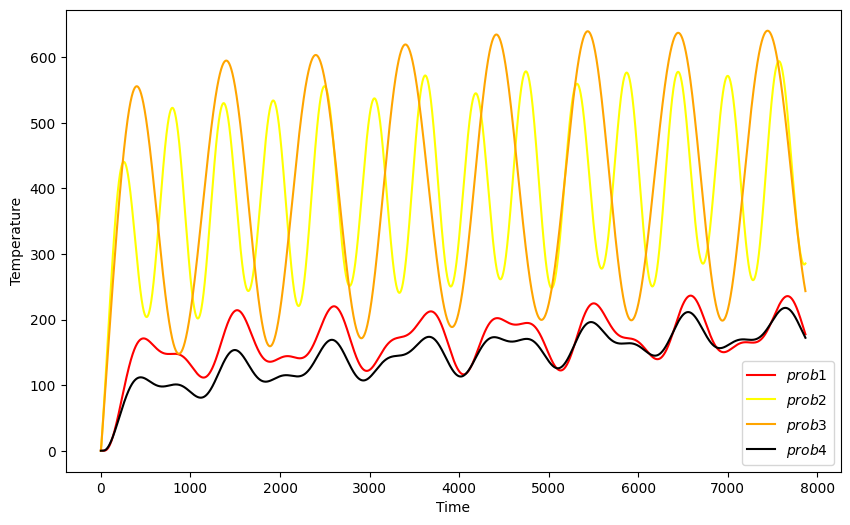

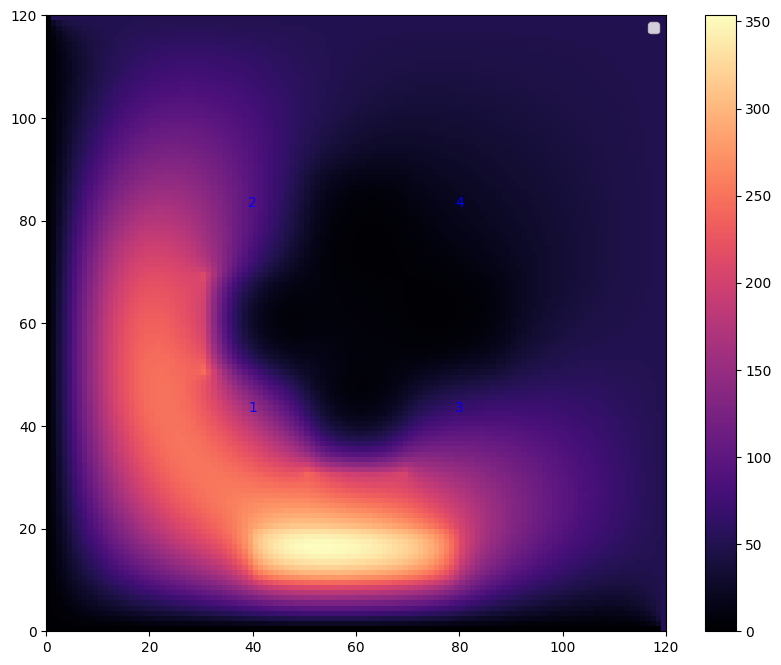

In [ ]:
prob1_r = np.load('prob1.npy')
prob2_r = np.load('prob2.npy')
prob3_r = np.load('prob3.npy')
prob4_r = np.load('prob4.npy')
probs = [prob1_r, prob2_r, prob3_r, prob4_r]
print(probs)
j = 1
for i in probs:
  i_aproximate = np.poly1d(np.polyfit(np.arange(len(i)), i, deg=3))(np.arange(len(i)))
  smeshenie = i - i_aproximate
  periods = approx_per(smeshenie, dt)
  print("период пробы"+str(j), periods)
  j += 1
plt.figure(figsize=(10, 6))
plt.plot(prob1, label='$'+"prob1"+'$', color='red')
plt.plot(prob2, label='$'+"prob2"+'$', color='yellow')
plt.plot(prob3, label='$'+"prob3"+'$', color='orange')
plt.plot(prob4, label='$'+"prob4"+'$', color='black')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


Temp = np.load('t1.npy')
plt.figure(figsize=(10, 8))
plt.scatter(x_t, y_t, c='red')
for i, (x_val, y_val) in enumerate(zip(x_t, y_t)):
    plt.annotate(i+1, (x_val, y_val), textcoords="offset points", xytext=(0,10), ha='center', color='blue')  # подпись номеров точек
plt.colorbar(plt.pcolormesh(Temp, cmap='magma'))
plt.legend()
plt.show()

[array([0.00000000e+00, 7.91507282e-21, 6.95314992e-19, ...,
       1.79780071e+02, 1.79712778e+02, 1.79645552e+02]), array([0.00000000e+00, 8.83462872e-16, 1.35419981e-14, ...,
       9.38778387e+01, 9.38485454e+01, 9.38193068e+01]), array([0.00000000e+00, 8.82388099e-16, 1.35244177e-14, ...,
       9.62458757e+01, 9.62108187e+01, 9.61757738e+01]), array([0.00000000e+00, 7.69996544e-57, 1.02787634e-55, ...,
       1.74269174e+01, 1.74271695e+01, 1.74274216e+01])]
период пробы1 [299.99159679  74.9978992   42.8559424 ]
период пробы2 [299.99159679  42.8559424 ]
период пробы3 [299.99159679  74.9978992 ]
период пробы4 [299.99159679]


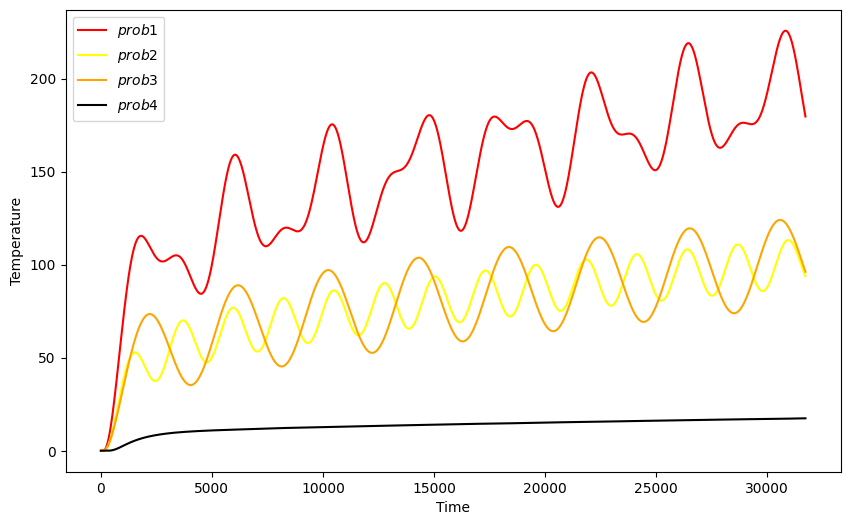

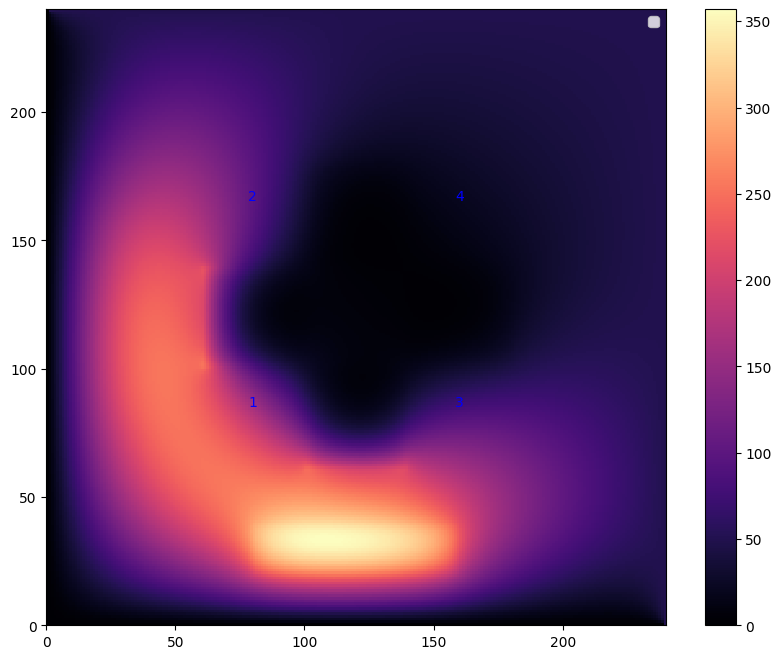

In [ ]:
prob1_r = np.load('prob1.npy')
prob2_r = np.load('prob2.npy')
prob3_r = np.load('prob3.npy')
prob4_r = np.load('prob4.npy')
probs = [prob1_r, prob2_r, prob3_r, prob4_r]
print(probs)
j = 1
for i in probs:
  i_aproximate = np.poly1d(np.polyfit(np.arange(len(i)), i, deg=3))(np.arange(len(i)))
  smeshenie = i - i_aproximate
  periods = approx_per(smeshenie, dt)
  print("период пробы"+str(j), periods)
  j += 1
plt.figure(figsize=(10, 6))
plt.plot(prob1, label='$'+"prob1"+'$', color='red')
plt.plot(prob2, label='$'+"prob2"+'$', color='yellow')
plt.plot(prob3, label='$'+"prob3"+'$', color='orange')
plt.plot(prob4, label='$'+"prob4"+'$', color='black')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


Temp = np.load('t1.npy')
plt.figure(figsize=(10, 8))
plt.scatter(x_t, y_t, c='red')
for i, (x_val, y_val) in enumerate(zip(x_t, y_t)):
    plt.annotate(i+1, (x_val, y_val), textcoords="offset points", xytext=(0,10), ha='center', color='blue')  # подпись номеров точек
plt.colorbar(plt.pcolormesh(t_n, cmap='magma'))
plt.legend()
plt.show()

[array([0.00000000e+00, 4.53985662e-42, 1.44092981e-39, ...,
       1.83122236e+02, 1.83105158e+02, 1.83088085e+02]), array([0.00000000e+00, 4.20589353e-31, 1.19398752e-29, ...,
       9.71289268e+01, 9.71213026e+01, 9.71136818e+01]), array([0.00000000e+00, 4.20461699e-31, 1.19361238e-29, ...,
       9.96232774e+01, 9.96142286e+01, 9.96051806e+01]), array([0.00000000e+000, 2.41486347e-263, 5.59416949e-105, ...,
       1.72585399e+001, 1.72586036e+001, 1.72586672e+001])]
период пробы1 [299.99947699  74.99986925  42.85706814]
период пробы2 [299.99947699  42.85706814]
период пробы3 [299.99947699  74.99986925]
период пробы4 [299.99947699]


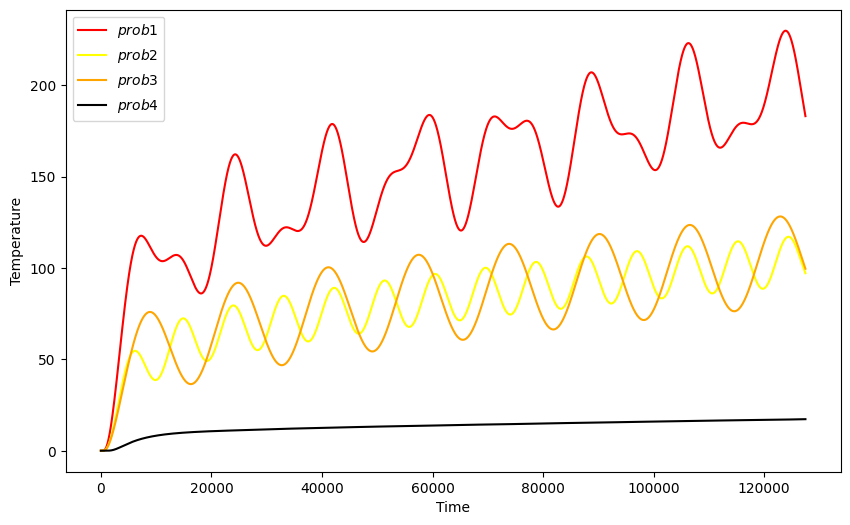

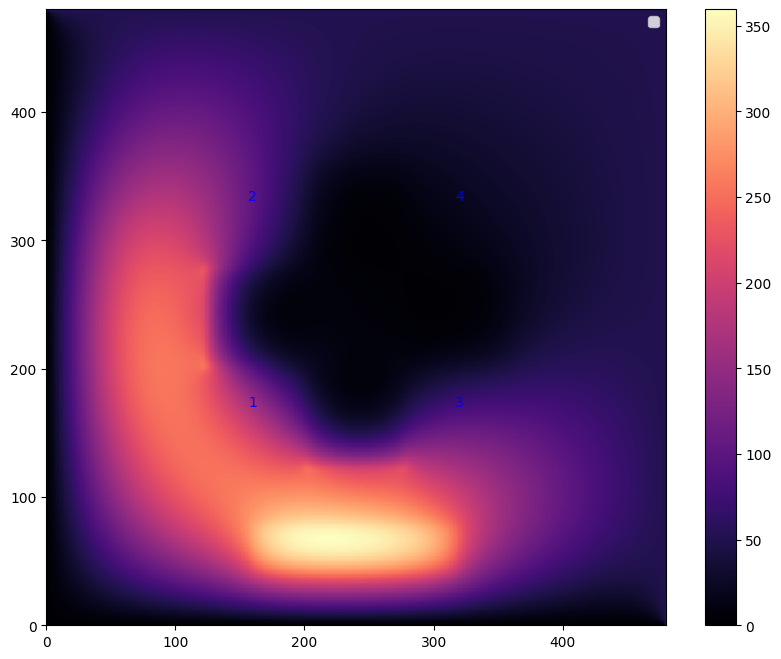

In [ ]:
prob1_r = np.load('prob1.npy')
prob2_r = np.load('prob2.npy')
prob3_r = np.load('prob3.npy')
prob4_r = np.load('prob4.npy')
probs = [prob1_r, prob2_r, prob3_r, prob4_r]
print(probs)
j = 1
for i in probs:
  i_aproximate = np.poly1d(np.polyfit(np.arange(len(i)), i, deg=3))(np.arange(len(i)))
  smeshenie = i - i_aproximate
  periods = approx_per(smeshenie, dt)
  print("период пробы"+str(j), periods)
  j += 1
plt.figure(figsize=(10, 6))
plt.plot(prob1, label='$'+"prob1"+'$', color='red')
plt.plot(prob2, label='$'+"prob2"+'$', color='yellow')
plt.plot(prob3, label='$'+"prob3"+'$', color='orange')
plt.plot(prob4, label='$'+"prob4"+'$', color='black')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


Temp = np.load('t1.npy')
plt.figure(figsize=(10, 8))
plt.scatter(x_t, y_t, c='red')
for i, (x_val, y_val) in enumerate(zip(x_t, y_t)):
    plt.annotate(i+1, (x_val, y_val), textcoords="offset points", xytext=(0,10), ha='center', color='blue')  # подпись номеров точек
plt.colorbar(plt.pcolormesh(Temp, cmap='magma'))
plt.legend()
plt.show()

[array([0.00000000e+00, 3.25695483e-84, 3.93598003e-81, ...,
       1.84760710e+02, 1.84756403e+02, 1.84752096e+02]), array([0.00000000e+00, 3.82437571e-61, 2.08468157e-59, ...,
       9.87791698e+01, 9.87772212e+01, 9.87752728e+01]), array([0.00000000e+00, 3.82408599e-61, 2.08452074e-59, ...,
       1.01321558e+02, 1.01319258e+02, 1.01316958e+02]), array([0.00000000e+000, 0.00000000e+000, 1.35972258e-205, ...,
       1.71756039e+001, 1.71756199e+001, 1.71756359e+001])]
период пробы1 [299.99947808  74.99986952  42.8570683 ]
период пробы2 [299.99947808  42.8570683 ]
период пробы3 [299.99947808  74.99986952]
период пробы4 [299.99947808]


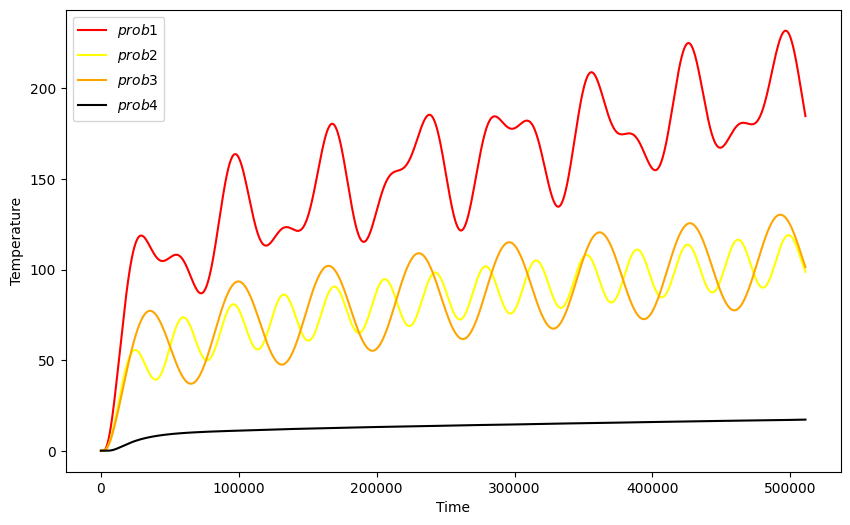

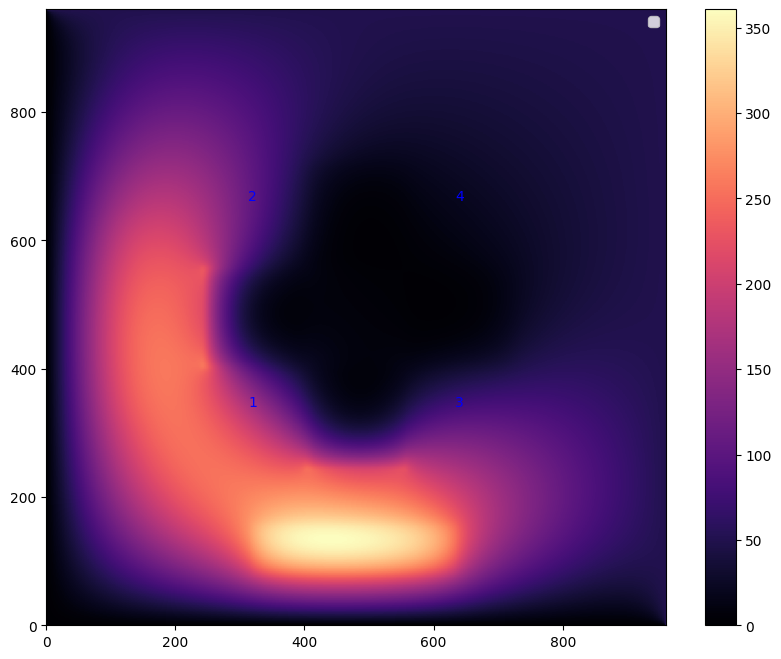

In [ ]:
prob1_r = np.load('prob1.npy')
prob2_r = np.load('prob2.npy')
prob3_r = np.load('prob3.npy')
prob4_r = np.load('prob4.npy')
probs = [prob1_r, prob2_r, prob3_r, prob4_r]
print(probs)
j = 1
for i in probs:
  i_aproximate = np.poly1d(np.polyfit(np.arange(len(i)), i, deg=3))(np.arange(len(i)))
  smeshenie = i - i_aproximate
  periods = approx_per(smeshenie, dt)
  print("период пробы"+str(j), periods)
  j += 1
plt.figure(figsize=(10, 6))
plt.plot(prob1, label='$'+"prob1"+'$', color='red')
plt.plot(prob2, label='$'+"prob2"+'$', color='yellow')
plt.plot(prob3, label='$'+"prob3"+'$', color='orange')
plt.plot(prob4, label='$'+"prob4"+'$', color='black')

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


Temp = np.load('t1.npy')
plt.figure(figsize=(10, 8))
plt.scatter(x_t, y_t, c='red')
for i, (x_val, y_val) in enumerate(zip(x_t, y_t)):
    plt.annotate(i+1, (x_val, y_val), textcoords="offset points", xytext=(0,10), ha='center', color='blue')  # подпись номеров точек
plt.colorbar(plt.pcolormesh(Temp, cmap='magma'))
plt.legend()
plt.show()